In [19]:
# use magic command to auto-reload
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import igraph as ig
import json
from dotenv import load_dotenv
import requests

sys.path.insert(0, os.path.join(os.getcwd(), '..'))  # parent folder of src
from src.simulation import run_simulation
from src.save import save_simulation_results, show_discussion_from_saved, load_replica
from src.visualization import show_interactive_conversation_tree_with_agent_selection
from metrics import *
import dotenv
import os
import asyncio
import aiohttp
# Load environment variables
env = dotenv.dotenv_values(".env")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def send_prompt(prompt):
    env = dotenv.dotenv_values(".env")
    
    headers = {"Authorization": f"Bearer {env['HF_TOKEN']}"}
    
    payload = {
        "messages": prompt,
        "model": env["MODEL"],
        "max_tokens": 128,
        "temperature": 0.7
    }
    
    response = requests.post(env["API_URL"], headers=headers, json=payload)
    
    return response.json()["choices"][0]["message"]["content"]

In [3]:
# define a class similar to a c++ struct
# "message". It needs: sender, content, timestamp.
# It should have a method to print the message in a readable format.


class Message:
    def __init__(self, sender, content, timestamp):
        self.sender = sender
        self.content = content
        self.timestamp = timestamp
    
    def print(self):
        print(f"{self.sender}: {self.content} ({self.timestamp})")


In [11]:
def assemble_prompt(self_name, messages):
    prompt = []
    prompt.append({"role": "system", "content": print_default_prompt()})
    for message in messages:
        content = f"{message.sender}: {message.content} ({message.timestamp})"
        if message.sender == self_name:
            prompt.append({"role": "user", "content": content})
        else:
            prompt.append({"role": "assistant", "content": content})
    return prompt
def print_default_prompt():
        return "You are Sarah, a 28-year-old teacher who strongly supports universal healthcare. You're in a group discussion about healthcare policy."


In [5]:
def visualize_prompt(prompt):
    for message in prompt:
        role = message["role"]
        content = message["content"]
        
        if role == "system":
            print("=" * 80)
            print("SYSTEM PROMPT")
            print("=" * 80)
            print(content)
            print()
        elif role == "user":
            print("-" * 80)
            print("USER MESSAGE")
            print("-" * 80)
            print(content)
            print()
        elif role == "assistant":
            print("-" * 80)
            print("ASSISTANT MESSAGE")
            print("-" * 80)
            print(content)
            print()

In [6]:
# Thread 1: Simple agreement chain
thread1 = [
    Message("Mike", "Healthcare costs are too high", "2025-01-01 12:00:00"),
    Message("Lisa", "I agree, many families struggle with medical bills", "2025-01-01 12:01:00"),
    Message("Tom", "We need to find a solution soon", "2025-01-01 12:02:00")
]

# Thread 2: Simple disagreement
thread2 = [
    Message("Mike", "Universal healthcare is the only solution", "2025-01-01 12:00:00"),
    Message("Lisa", "No, the free market can solve this better", "2025-01-01 12:01:00"),
    Message("Tom", "Both approaches have merit", "2025-01-01 12:02:00")
]

# Thread 3: Multi-point argument with statistics
thread3 = [
    Message("Mike", "Universal healthcare works in 32 developed countries", "2025-01-01 12:00:00"),
    Message("Lisa", "But those countries have smaller populations and higher taxes", "2025-01-01 12:01:00"),
    Message("Tom", "Canada has 38 million people and it works there", "2025-01-01 12:02:00"),
    Message("Mike", "Exactly, and their healthcare costs per capita are half of ours", "2025-01-01 12:03:00")
]

# Thread 4: Emotional argument with personal stories
thread4 = [
    Message("Mike", "My sister died because she couldn't afford insulin", "2025-01-01 12:00:00"),
    Message("Lisa", "I'm sorry for your loss, but government control means longer wait times", "2025-01-01 12:01:00"),
    Message("Tom", "My friend in Canada waited 6 months for knee surgery", "2025-01-01 12:02:00"),
    Message("Mike", "But at least he got the surgery. My sister never got her insulin", "2025-01-01 12:03:00"),
    Message("Lisa", "We need a hybrid system that combines efficiency and access", "2025-01-01 12:04:00")
]

# Thread 5: Complex multi-layered debate with counterarguments
thread5 = [
    Message("Mike", "Studies show universal healthcare reduces overall costs by 15-20%", "2025-01-01 12:00:00"),
    Message("Lisa", "Those studies don't account for reduced innovation in medical technology", "2025-01-01 12:01:00"),
    Message("Tom", "But most medical innovation happens in universities, not private companies", "2025-01-01 12:02:00"),
    Message("Mike", "And pharmaceutical companies spend more on marketing than R&D anyway", "2025-01-01 12:03:00"),
    Message("Lisa", "That's misleading. Marketing includes educating doctors about new treatments", "2025-01-01 12:04:00"),
    Message("Tom", "Can we agree that some regulation is needed, even if not full universal healthcare?", "2025-01-01 12:05:00"),
    Message("Mike", "Regulation hasn't worked. We've been regulating for decades and costs keep rising", "2025-01-01 12:06:00"),
    Message("Lisa", "Because the regulations create bureaucracy, not competition", "2025-01-01 12:07:00")
]

# Thread 6: Extended debate with shifting arguments (8 messages)
thread6 = [
    Message("Mike", "Universal healthcare would save the US $450 billion annually according to Yale studies", "2025-01-01 12:00:00"),
    Message("Lisa", "Those studies assume perfect implementation with zero bureaucratic waste", "2025-01-01 12:01:00"),
    Message("Tom", "Even with 20% waste, we'd still save $360 billion. That's massive", "2025-01-01 12:02:00"),
    Message("Mike", "And current private insurance has 12-18% administrative overhead anyway", "2025-01-01 12:03:00"),
    Message("Lisa", "But Medicare has fraud rates of 10%. Scale that to the whole population", "2025-01-01 12:04:00"),
    Message("Tom", "Private insurance fraud is estimated at 15%. Medicare is actually better", "2025-01-01 12:05:00"),
    Message("Mike", "Plus, 45,000 Americans die yearly from lack of insurance. What's the cost of that?", "2025-01-01 12:06:00"),
    Message("Lisa", "That statistic is contested. Many factors contribute to those deaths", "2025-01-01 12:07:00"),
]

# Thread 7: Personal narratives with complex emotional layers (10 messages)
thread7 = [
    Message("Mike", "I lost my job and my insurance at the same time. That's when I got diagnosed with cancer", "2025-01-01 12:00:00"),
    Message("Lisa", "That's terrible Mike. But government healthcare wouldn't necessarily have caught it earlier", "2025-01-01 12:01:00"),
    Message("Tom", "My cousin in France had breast cancer. Free screening found it at stage 1. She's alive today", "2025-01-01 12:02:00"),
    Message("Mike", "Exactly. I couldn't afford screening when I was uninsured. Found mine at stage 3", "2025-01-01 12:03:00"),
    Message("Lisa", "I'm genuinely sorry for both of you. But my father waited 8 months for surgery in Canada", "2025-01-01 12:04:00"),
    Message("Tom", "Was it life-threatening? Urgent cases get prioritized in those systems", "2025-01-01 12:05:00"),
    Message("Lisa", "It was a hip replacement. He was in constant pain, couldn't work", "2025-01-01 12:06:00"),
    Message("Mike", "In the US, 30% of people skip necessary procedures because of cost. That's also suffering", "2025-01-01 12:07:00"),
    Message("Tom", "We're comparing wait times to no access at all. Which is worse?", "2025-01-01 12:08:00"),
    Message("Lisa", "Both are unacceptable. Why can't we demand better than both options?", "2025-01-01 12:09:00"),
]

# Thread 8: Multi-dimensional policy discussion (12 messages)
thread8 = [
    Message("Mike", "Universal healthcare should cover dental and vision too. Health is holistic", "2025-01-01 12:00:00"),
    Message("Lisa", "Now you're expanding scope. That makes costs unpredictable and unsustainable", "2025-01-01 12:01:00"),
    Message("Tom", "UK includes dental for children. Adults pay small fees. It's manageable", "2025-01-01 12:02:00"),
    Message("Mike", "Poor dental health links to heart disease, diabetes complications. It's preventive", "2025-01-01 12:03:00"),
    Message("Lisa", "So does obesity, but we don't provide free gym memberships", "2025-01-01 12:04:00"),
    Message("Tom", "Some European systems actually do provide wellness programs and fitness subsidies", "2025-01-01 12:05:00"),
    Message("Mike", "Because prevention is cheaper than treatment. This isn't radical, it's economics", "2025-01-01 12:06:00"),
    Message("Lisa", "Then why not focus on prevention in our current system rather than rebuilding everything?", "2025-01-01 12:07:00"),
    Message("Tom", "Because insurers profit from treatment, not prevention. The incentive structure is wrong", "2025-01-01 12:08:00"),
    Message("Mike", "Health insurance shouldn't be a for-profit industry. That's the fundamental issue", "2025-01-01 12:09:00"),
    Message("Lisa", "Non-profits exist now. Blue Cross started as non-profit. They have the same problems", "2025-01-01 12:10:00"),
    Message("Tom", "Because they operate in a broken system. You need systemic change, not individual fixes", "2025-01-01 12:11:00"),
]

# Thread 9: Technical policy details with counterarguments (15 messages)
thread9 = [
    Message("Mike", "Single-payer eliminates administrative duplication across 900+ insurance companies", "2025-01-01 12:00:00"),
    Message("Lisa", "It also eliminates competition that drives innovation and efficiency", "2025-01-01 12:01:00"),
    Message("Tom", "Healthcare isn't a normal market. Consumers can't shop around during emergencies", "2025-01-01 12:02:00"),
    Message("Mike", "And information asymmetry is huge. Patients can't evaluate quality of care like products", "2025-01-01 12:03:00"),
    Message("Lisa", "That's why we need better transparency, not government monopoly", "2025-01-01 12:04:00"),
    Message("Tom", "We've tried transparency. Price posting laws haven't reduced costs meaningfully", "2025-01-01 12:05:00"),
    Message("Mike", "Taiwan transitioned to single-payer in 1995. 99.9% coverage, costs 6.5% of GDP", "2025-01-01 12:06:00"),
    Message("Lisa", "Taiwan is culturally homogeneous with 23 million people. The US has 330 million and huge diversity", "2025-01-01 12:07:00"),
    Message("Tom", "Canada has geographic challenges similar to the US. Ten provinces, vast rural areas", "2025-01-01 12:08:00"),
    Message("Mike", "And they spend $5,500 per capita versus our $12,500. We're paying double for worse outcomes", "2025-01-01 12:09:00"),
    Message("Lisa", "Our outcomes are worse because of lifestyle factors, not healthcare system structure", "2025-01-01 12:10:00"),
    Message("Tom", "Life expectancy correlates with universal coverage even controlling for lifestyle", "2025-01-01 12:11:00"),
    Message("Mike", "Infant mortality too. We rank 33rd globally. Every country above us has universal care", "2025-01-01 12:12:00"),
    Message("Lisa", "Our infant mortality calculation includes premature births other countries don't report", "2025-01-01 12:13:00"),
    Message("Tom", "That's been debunked. The WHO standardized definitions. Our ranking is accurate", "2025-01-01 12:14:00"),
]

# Thread 10: Hostile debate with ad hominem and emotional escalation (18 messages)
thread10 = [
    Message("Mike", "Anyone against universal healthcare either doesn't understand economics or doesn't care about people dying", "2025-01-01 12:00:00"),
    Message("Lisa", "That's an offensive false dichotomy. I care deeply but disagree on solutions", "2025-01-01 12:01:00"),
    Message("Tom", "Mike has a point though. The evidence is overwhelming. Opposition seems ideological", "2025-01-01 12:02:00"),
    Message("Lisa", "So everyone who disagrees with you is just irrational? That's incredibly arrogant", "2025-01-01 12:03:00"),
    Message("Mike", "I've provided statistics, international comparisons, economic studies. What's your evidence?", "2025-01-01 12:04:00"),
    Message("Lisa", "Cherry-picked data doesn't make you right. Venezuela had universal healthcare. How's that working?", "2025-01-01 12:05:00"),
    Message("Tom", "Venezuela collapsed from corruption and oil dependence, not healthcare policy", "2025-01-01 12:06:00"),
    Message("Mike", "Using Venezuela is such bad faith. Every developed democracy with universal healthcare succeeds", "2025-01-01 12:07:00"),
    Message("Lisa", "Bad faith? You're the one calling people murderers for disagreeing with you", "2025-01-01 12:08:00"),
    Message("Tom", "Nobody said murderers. But policies have consequences. People die from lack of coverage", "2025-01-01 12:09:00"),
    Message("Lisa", "And people die in systems with universal coverage too. The UK has horrible cancer survival rates", "2025-01-01 12:10:00"),
    Message("Mike", "That's misleading. UK catches more early-stage cancers, which lowers survival statistics", "2025-01-01 12:11:00"),
    Message("Lisa", "You have an explanation for everything. Maybe your ideology is blinding you", "2025-01-01 12:12:00"),
    Message("Tom", "Can we focus on data instead of attacking each other's motives?", "2025-01-01 12:13:00"),
    Message("Mike", "I've been presenting data. Lisa keeps deflecting with whataboutism", "2025-01-01 12:14:00"),
    Message("Lisa", "I'm raising legitimate concerns. You're dismissing anything that doesn't fit your narrative", "2025-01-01 12:15:00"),
    Message("Tom", "Let's take a step back. What would it take to change your mind, Lisa?", "2025-01-01 12:16:00"),
    Message("Lisa", "Evidence that a US implementation wouldn't compromise quality or innovation. Which nobody has provided", "2025-01-01 12:17:00"),
]

# Thread 11: 3 messages - baseline neutral tone
thread11 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
]

# Thread 12: 4 messages
thread12 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
]

# Thread 13: 6 messages
thread13 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
    Message("Lisa", "Canada's administrative costs are 2% of total spending", "2025-01-01 12:04:00"),
    Message("Tom", "That suggests potential savings of 6% through efficiency", "2025-01-01 12:05:00"),
]

# Thread 14: 8 messages
thread14 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
    Message("Lisa", "Canada's administrative costs are 2% of total spending", "2025-01-01 12:04:00"),
    Message("Tom", "That suggests potential savings of 6% through efficiency", "2025-01-01 12:05:00"),
    Message("Mike", "The US has 900 insurance companies with separate billing", "2025-01-01 12:06:00"),
    Message("Lisa", "Single-payer systems have one standardized billing process", "2025-01-01 12:07:00"),
]

# Thread 15: 10 messages
thread15 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
    Message("Lisa", "Canada's administrative costs are 2% of total spending", "2025-01-01 12:04:00"),
    Message("Tom", "That suggests potential savings of 6% through efficiency", "2025-01-01 12:05:00"),
    Message("Mike", "The US has 900 insurance companies with separate billing", "2025-01-01 12:06:00"),
    Message("Lisa", "Single-payer systems have one standardized billing process", "2025-01-01 12:07:00"),
    Message("Tom", "Prescription drug costs are 12% of total healthcare spending", "2025-01-01 12:08:00"),
    Message("Mike", "Other countries negotiate drug prices nationally", "2025-01-01 12:09:00"),
]

# Thread 16: 12 messages
thread16 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
    Message("Lisa", "Canada's administrative costs are 2% of total spending", "2025-01-01 12:04:00"),
    Message("Tom", "That suggests potential savings of 6% through efficiency", "2025-01-01 12:05:00"),
    Message("Mike", "The US has 900 insurance companies with separate billing", "2025-01-01 12:06:00"),
    Message("Lisa", "Single-payer systems have one standardized billing process", "2025-01-01 12:07:00"),
    Message("Tom", "Prescription drug costs are 12% of total healthcare spending", "2025-01-01 12:08:00"),
    Message("Mike", "Other countries negotiate drug prices nationally", "2025-01-01 12:09:00"),
    Message("Lisa", "The US pays 2.5 times more for prescription drugs on average", "2025-01-01 12:10:00"),
    Message("Tom", "Medicare Part D negotiation was prohibited until 2022", "2025-01-01 12:11:00"),
]

# Thread 17: 14 messages
thread17 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
    Message("Lisa", "Canada's administrative costs are 2% of total spending", "2025-01-01 12:04:00"),
    Message("Tom", "That suggests potential savings of 6% through efficiency", "2025-01-01 12:05:00"),
    Message("Mike", "The US has 900 insurance companies with separate billing", "2025-01-01 12:06:00"),
    Message("Lisa", "Single-payer systems have one standardized billing process", "2025-01-01 12:07:00"),
    Message("Tom", "Prescription drug costs are 12% of total healthcare spending", "2025-01-01 12:08:00"),
    Message("Mike", "Other countries negotiate drug prices nationally", "2025-01-01 12:09:00"),
    Message("Lisa", "The US pays 2.5 times more for prescription drugs on average", "2025-01-01 12:10:00"),
    Message("Tom", "Medicare Part D negotiation was prohibited until 2022", "2025-01-01 12:11:00"),
    Message("Mike", "Hospital costs represent 33% of total healthcare spending", "2025-01-01 12:12:00"),
    Message("Lisa", "The average hospital stay costs $12,000 in the US", "2025-01-01 12:13:00"),
]

# Thread 18: 16 messages
thread18 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
    Message("Lisa", "Canada's administrative costs are 2% of total spending", "2025-01-01 12:04:00"),
    Message("Tom", "That suggests potential savings of 6% through efficiency", "2025-01-01 12:05:00"),
    Message("Mike", "The US has 900 insurance companies with separate billing", "2025-01-01 12:06:00"),
    Message("Lisa", "Single-payer systems have one standardized billing process", "2025-01-01 12:07:00"),
    Message("Tom", "Prescription drug costs are 12% of total healthcare spending", "2025-01-01 12:08:00"),
    Message("Mike", "Other countries negotiate drug prices nationally", "2025-01-01 12:09:00"),
    Message("Lisa", "The US pays 2.5 times more for prescription drugs on average", "2025-01-01 12:10:00"),
    Message("Tom", "Medicare Part D negotiation was prohibited until 2022", "2025-01-01 12:11:00"),
    Message("Mike", "Hospital costs represent 33% of total healthcare spending", "2025-01-01 12:12:00"),
    Message("Lisa", "The average hospital stay costs $12,000 in the US", "2025-01-01 12:13:00"),
    Message("Tom", "Comparable stays in OECD countries average $6,000", "2025-01-01 12:14:00"),
    Message("Mike", "Physician salaries are 20% higher in the US than abroad", "2025-01-01 12:15:00"),
]

# Thread 19: 18 messages
thread19 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
    Message("Lisa", "Canada's administrative costs are 2% of total spending", "2025-01-01 12:04:00"),
    Message("Tom", "That suggests potential savings of 6% through efficiency", "2025-01-01 12:05:00"),
    Message("Mike", "The US has 900 insurance companies with separate billing", "2025-01-01 12:06:00"),
    Message("Lisa", "Single-payer systems have one standardized billing process", "2025-01-01 12:07:00"),
    Message("Tom", "Prescription drug costs are 12% of total healthcare spending", "2025-01-01 12:08:00"),
    Message("Mike", "Other countries negotiate drug prices nationally", "2025-01-01 12:09:00"),
    Message("Lisa", "The US pays 2.5 times more for prescription drugs on average", "2025-01-01 12:10:00"),
    Message("Tom", "Medicare Part D negotiation was prohibited until 2022", "2025-01-01 12:11:00"),
    Message("Mike", "Hospital costs represent 33% of total healthcare spending", "2025-01-01 12:12:00"),
    Message("Lisa", "The average hospital stay costs $12,000 in the US", "2025-01-01 12:13:00"),
    Message("Tom", "Comparable stays in OECD countries average $6,000", "2025-01-01 12:14:00"),
    Message("Mike", "Physician salaries are 20% higher in the US than abroad", "2025-01-01 12:15:00"),
    Message("Lisa", "Medical school debt averages $200,000 in the US", "2025-01-01 12:16:00"),
    Message("Tom", "Most European countries provide free medical education", "2025-01-01 12:17:00"),
]

# Thread 20: 20 messages
thread20 = [
    Message("Mike", "Healthcare spending in the US is 17% of GDP", "2025-01-01 12:00:00"),
    Message("Lisa", "Most other developed countries spend 9-12% of GDP", "2025-01-01 12:01:00"),
    Message("Tom", "The difference is about $1.5 trillion annually", "2025-01-01 12:02:00"),
    Message("Mike", "Administrative costs account for 8% of total spending", "2025-01-01 12:03:00"),
    Message("Lisa", "Canada's administrative costs are 2% of total spending", "2025-01-01 12:04:00"),
    Message("Tom", "That suggests potential savings of 6% through efficiency", "2025-01-01 12:05:00"),
    Message("Mike", "The US has 900 insurance companies with separate billing", "2025-01-01 12:06:00"),
    Message("Lisa", "Single-payer systems have one standardized billing process", "2025-01-01 12:07:00"),
    Message("Tom", "Prescription drug costs are 12% of total healthcare spending", "2025-01-01 12:08:00"),
    Message("Mike", "Other countries negotiate drug prices nationally", "2025-01-01 12:09:00"),
    Message("Lisa", "The US pays 2.5 times more for prescription drugs on average", "2025-01-01 12:10:00"),
    Message("Tom", "Medicare Part D negotiation was prohibited until 2022", "2025-01-01 12:11:00"),
    Message("Mike", "Hospital costs represent 33% of total healthcare spending", "2025-01-01 12:12:00"),
    Message("Lisa", "The average hospital stay costs $12,000 in the US", "2025-01-01 12:13:00"),
    Message("Tom", "Comparable stays in OECD countries average $6,000", "2025-01-01 12:14:00"),
    Message("Mike", "Physician salaries are 20% higher in the US than abroad", "2025-01-01 12:15:00"),
    Message("Lisa", "Medical school debt averages $200,000 in the US", "2025-01-01 12:16:00"),
    Message("Tom", "Most European countries provide free medical education", "2025-01-01 12:17:00"),
    Message("Mike", "Preventive care utilization is 30% lower in the US", "2025-01-01 12:18:00"),
    Message("Lisa", "Countries with universal coverage have 60% preventive care rates", "2025-01-01 12:19:00"),
]
threads = [thread1, thread2, thread3, thread4, thread5, thread6, thread7, thread8, thread9, thread10]
neutral_threads = [thread11, thread12, thread13, thread14, thread15, thread16, thread17, thread18, thread19, thread20]

In [26]:

import matplotlib.pyplot as plt
def run_full_simulation(threads, num_runs=5, names=['Mike', 'Lisa', 'Tom']):
    num_threads = len(threads)
    
    # Initialize tracking for all possible categories
    categories = ['Last', 'Second-to-Last', 'Third-to-Last', 'First', 'Second', 'Third', 'None', 'Multiple', 'Other']
    category_counts = {cat: np.zeros((num_runs, num_threads)) for cat in categories}
    
    # Initialize 2D arrays for metrics: [run, thread]
    Length_all = np.zeros((num_runs, num_threads))
    Length_Ratio_all = np.zeros((num_runs, num_threads))
    Specificity_all = np.zeros((num_runs, num_threads))
    Engagement_all = np.zeros((num_runs, num_threads))
    Novelty_all = np.zeros((num_runs, num_threads))
    Complexity_all = np.zeros((num_runs, num_threads))
    Emotional_all = np.zeros((num_runs, num_threads))
    
    for run in range(num_runs):
        print(f"\n{'#'*80}")
        print(f"RUN {run + 1} of {num_runs}")
        print(f"{'#'*80}")
        
        for i, thread in enumerate(threads):
            print(f"\n{'='*80}")
            print(f"THREAD {i} ({len(thread)} messages)")
            print('='*80)
            
            prompt = assemble_prompt("Sarah", thread)
            response = send_prompt(prompt)
            
            metrics = analyze_response_comprehensive(response, thread)
            addressee_info = analyze_addressee_pattern(response, thread, names)
            
            print(f"SARAH'S RESPONSE: {response}\n")
            print(f"Metrics:")
            print(f"  Length: {metrics['length']}")
            Length_all[run, i] = metrics['length']
            print(f"  Length Ratio: {metrics['length_ratio']:.2f}")
            Length_Ratio_all[run, i] = metrics['length_ratio']
            print(f"  Specificity: {metrics['specificity']}")
            Specificity_all[run, i] = metrics['specificity']
            print(f"  Engagement: {metrics['engagement']}")
            Engagement_all[run, i] = metrics['engagement']
            print(f"  Novelty: {metrics['novelty']:.2f}")
            Novelty_all[run, i] = metrics['novelty']
            print(f"  Complexity: {metrics['complexity']:.1f}")
            Complexity_all[run, i] = metrics['complexity']
            print(f"  Emotional: {metrics['emotional']}")
            Emotional_all[run, i] = metrics['emotional']
            
            # Track category
            category = addressee_info['category']
            category_counts[category][run, i] = 1
            
            print(f"  Category: {category} (Addressee: {addressee_info['addressee']})")
    
    # Calculate means and stds
    results = {
        'Length_mean': np.mean(Length_all, axis=0),
        'Length_std': np.std(Length_all, axis=0),
        'Length_Ratio_mean': np.mean(Length_Ratio_all, axis=0),
        'Length_Ratio_std': np.std(Length_Ratio_all, axis=0),
        'Specificity_mean': np.mean(Specificity_all, axis=0),
        'Specificity_std': np.std(Specificity_all, axis=0),
        'Engagement_mean': np.mean(Engagement_all, axis=0),
        'Engagement_std': np.std(Engagement_all, axis=0),
        'Novelty_mean': np.mean(Novelty_all, axis=0),
        'Novelty_std': np.std(Novelty_all, axis=0),
        'Complexity_mean': np.mean(Complexity_all, axis=0),
        'Complexity_std': np.std(Complexity_all, axis=0),
        'Emotional_mean': np.mean(Emotional_all, axis=0),
        'Emotional_std': np.std(Emotional_all, axis=0),
    }
    
    # Add all category means
    for cat in categories:
        results[f'Addressee_{cat}_mean'] = np.mean(category_counts[cat], axis=0)
    
    return results


def plot_results(results, threads):
    # Plot 1: Addressee patterns
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(threads))
    width = 0.6
    
    bottom = np.zeros(len(threads))
    
    p1 = ax.bar(x, results['Addressee_Last_mean'], width, label='Last Speaker', color='green', alpha=0.7, bottom=bottom)
    bottom += results['Addressee_Last_mean']
    
    p2 = ax.bar(x, results['Addressee_Second_mean'], width, label='Second Speaker', color='cyan', alpha=0.7, bottom=bottom)
    bottom += results['Addressee_Second_mean']
    
    p3 = ax.bar(x, results['Addressee_First_mean'], width, label='First Speaker', color='blue', alpha=0.7, bottom=bottom)
    bottom += results['Addressee_First_mean']
    
    p4 = ax.bar(x, results['Addressee_Multiple_mean'], width, label='Multiple', color='purple', alpha=0.7, bottom=bottom)
    bottom += results['Addressee_Multiple_mean']
    
    p5 = ax.bar(x, results['Addressee_Other_mean'], width, label='Other', color='orange', alpha=0.7, bottom=bottom)
    bottom += results['Addressee_Other_mean']
    
    p6 = ax.bar(x, results['Addressee_None_mean'], width, label='Nobody', color='red', alpha=0.7, bottom=bottom)
    
    ax.set_xlabel('Thread Number', fontsize=12)
    ax.set_ylabel('Proportion of Responses', fontsize=12)
    ax.set_title('Who Does Sarah Address? (Conversation Flow Tracking)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{i}' for i in range(len(threads))])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: All metrics in subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Model Performance (mean ± std, n=5)', fontsize=14)
    
    x = np.arange(len(threads))
    
    # Length
    axes[0, 0].plot(x, results['Length_mean'], marker='o', color='blue')
    axes[0, 0].fill_between(x, results['Length_mean'] - results['Length_std'], 
                             results['Length_mean'] + results['Length_std'], alpha=0.3, color='blue')
    axes[0, 0].set_title('Response Length')
    axes[0, 0].set_xlabel('Thread')
    axes[0, 0].set_ylabel('Characters')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Length Ratio
    axes[0, 1].plot(x, results['Length_Ratio_mean'], marker='o', color='orange')
    axes[0, 1].fill_between(x, results['Length_Ratio_mean'] - results['Length_Ratio_std'], 
                             results['Length_Ratio_mean'] + results['Length_Ratio_std'], alpha=0.3, color='orange')
    axes[0, 1].set_title('Length Ratio')
    axes[0, 1].set_xlabel('Thread')
    axes[0, 1].set_ylabel('Ratio')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Specificity
    axes[0, 2].plot(x, results['Specificity_mean'], marker='o', color='green')
    axes[0, 2].fill_between(x, results['Specificity_mean'] - results['Specificity_std'], 
                             results['Specificity_mean'] + results['Specificity_std'], alpha=0.3, color='green')
    axes[0, 2].set_title('Specificity')
    axes[0, 2].set_xlabel('Thread')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Engagement
    axes[0, 3].plot(x, results['Engagement_mean'], marker='o', color='red')
    axes[0, 3].fill_between(x, results['Engagement_mean'] - results['Engagement_std'], 
                             results['Engagement_mean'] + results['Engagement_std'], alpha=0.3, color='red')
    axes[0, 3].set_title('Engagement')
    axes[0, 3].set_xlabel('Thread')
    axes[0, 3].set_ylabel('Count')
    axes[0, 3].grid(True, alpha=0.3)
    
    # Novelty
    axes[1, 0].plot(x, results['Novelty_mean'], marker='o', color='purple')
    axes[1, 0].fill_between(x, results['Novelty_mean'] - results['Novelty_std'], 
                             results['Novelty_mean'] + results['Novelty_std'], alpha=0.3, color='purple')
    axes[1, 0].set_title('Novelty')
    axes[1, 0].set_xlabel('Thread')
    axes[1, 0].set_ylabel('Fraction')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Complexity
    axes[1, 1].plot(x, results['Complexity_mean'], marker='o', color='brown')
    axes[1, 1].fill_between(x, results['Complexity_mean'] - results['Complexity_std'], 
                             results['Complexity_mean'] + results['Complexity_std'], alpha=0.3, color='brown')
    axes[1, 1].set_title('Complexity')
    axes[1, 1].set_xlabel('Thread')
    axes[1, 1].set_ylabel('Words/Sentence')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Emotional
    axes[1, 2].plot(x, results['Emotional_mean'], marker='o', color='pink')
    axes[1, 2].fill_between(x, results['Emotional_mean'] - results['Emotional_std'], 
                             results['Emotional_mean'] + results['Emotional_std'], alpha=0.3, color='pink')
    axes[1, 2].set_title('Emotional Engagement')
    axes[1, 2].set_xlabel('Thread')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].grid(True, alpha=0.3)
    
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
results = run_full_simulation(neutral_threads, num_runs=5)


################################################################################
RUN 1 of 5
################################################################################

THREAD 0 (3 messages)
SARAH'S RESPONSE: Sarah: If we implemented a universal healthcare system like many other countries, we could potentially save that $1.5 trillion and allocate it towards other important sectors like education, infrastructure, or poverty reduction.

Metrics:
  Length: 228
  Length Ratio: 4.96
  Specificity: 1
  Engagement: 0
  Novelty: 0.86
  Complexity: 16.5
  Emotional: 0
  Category: None (Addressee: None)

THREAD 1 (4 messages)
SARAH'S RESPONSE: That's a huge inefficiency in our system. In countries with universal healthcare, like the UK, administrative costs are often a fraction of that. We need to look at ways to streamline our system, not just cut funding to programs that help the most vulnerable people. As a teacher, I've seen firsthand how health issues can impact a student's ability to

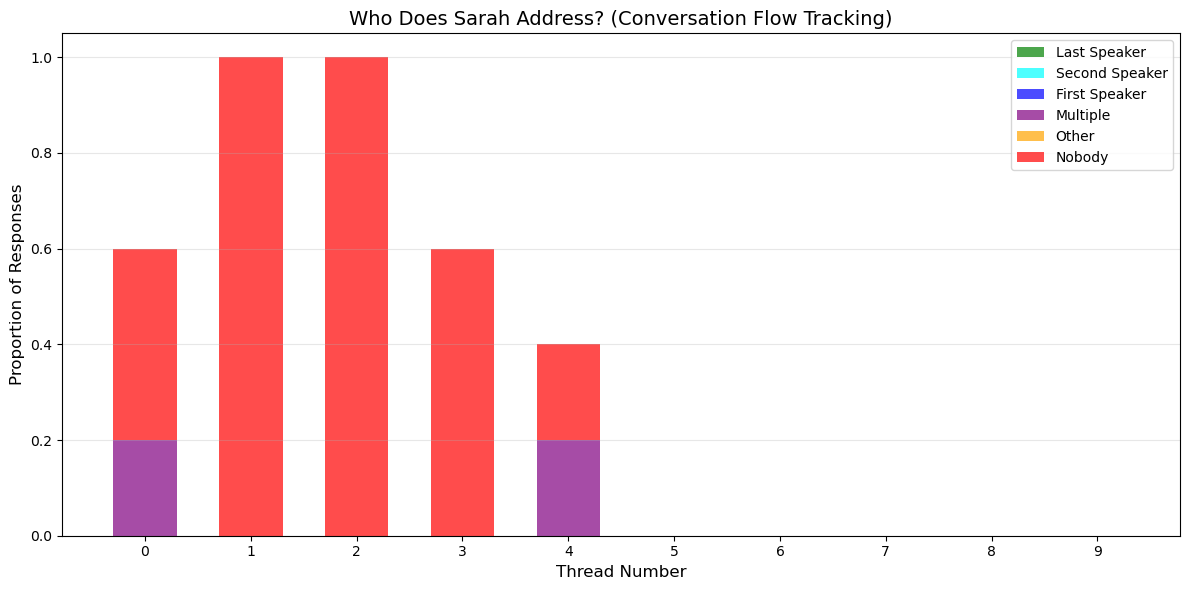

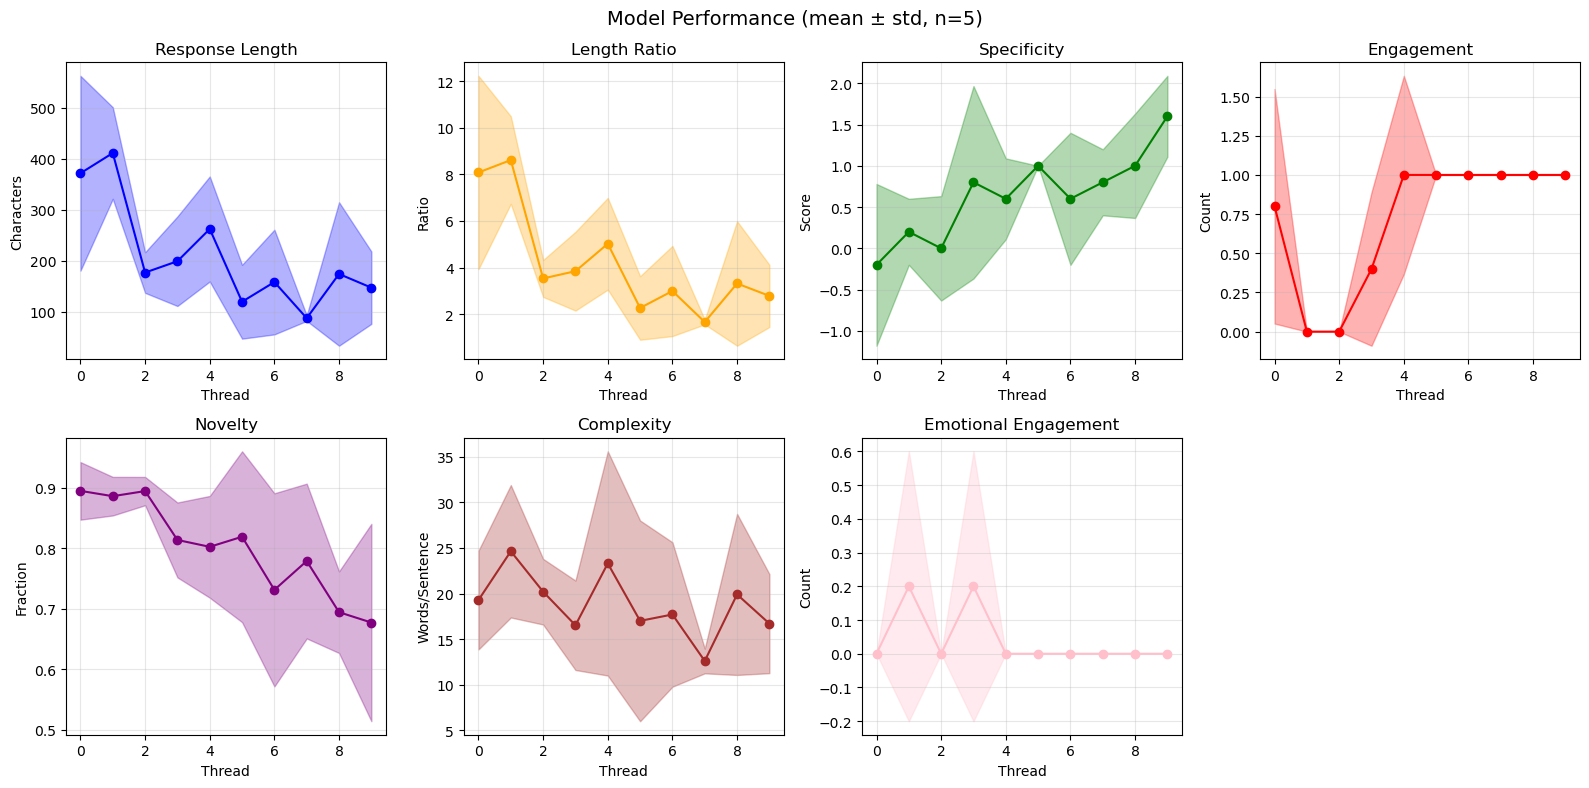

In [28]:
plot_results(results, neutral_threads)